In [1]:
import Trial_Processing as pts
import numpy as np
import matplotlib.pyplot as plt

In [18]:
test_experiment = pts.PhotometryVideoData('/home/murph_4090ws/Documents/Social_Interaction_Analysis/20230822_M5M6.csv', trim_start=12)

/home/murph_4090ws/Documents/Social_Interaction_Analysis/src/Trial_Processing.py:307: DtypeWarning: Columns (8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  self.df = pd.read_csv(photo_csv_path)


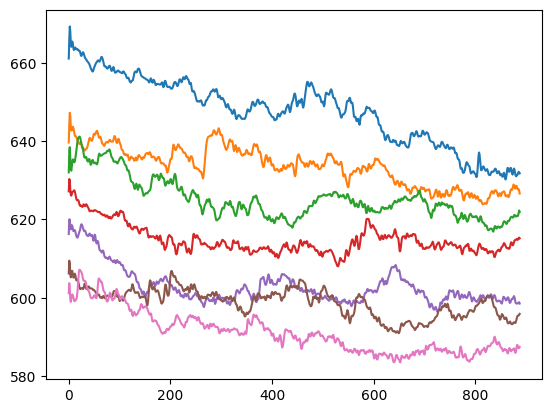

In [33]:
for i in range(7):
    plt.plot(test_experiment.get_photometry_data(i + 1)['465C'])
plt.show()